# Street_En Multi-class Prediction

# 1. Get Ready for street_en test dataset

## 1-1 Setting model and test data

In [51]:
model_folder = "DICTNET-STREET-EN-HARVEST/" #in models folder
model_name = "_iter_10000.caffemodel"
test_folder = "STREET-EN-RATIO-100/" #in testsets folder
model_type = 'vgg' #vgg or bvlc

## 1-2. Define Lexicon class

In [52]:
class Lexicon:
    def __init__(self,imageName,lex,num):
        self.imageName = imageName
        self.lex = lex 
        self.gt = lex[num]       
        
    def set_image_number(self,number):
        self.image_number = number
    
    def set_image_path(self,path):
        self.image_path = path

In [53]:
import numpy as np

lex_file = './street_en_labels.txt'
lex = np.loadtxt(lex_file, str, delimiter='\t')

print lex

['frazzoli' 'tedrake' 'asada' 'breazeal' 'dubowsky' 'herr' 'hoburg' 'hogan'
 'iagnemma' 'kaelbling' 'lozano' 'kim' 'reif' 'waltz' 'peraire' 'chandra'
 'kasan' 'micali' 'chen' 'hosoi' 'rus' 'how' 'roy' 'shah' 'williams'
 'leonard' 'brooks' 'karaman']


## 1-3. Ready testing dataset

* Read image data

In [54]:
import os

path = 'testsets/' + test_folder + '/'
test_path = np.loadtxt(path + 'test.txt', str, delimiter=' ')

if os.path.exists(path):
    dataList = []
    image_number = 0

    for itera,class_num in test_path:
        
        imageName = itera
        imageInfo = Lexicon(imageName,lex,int(class_num))
        imageInfo.set_image_number(image_number)
        image_number += 1
        img_path = path + itera
        imageInfo.set_image_path(img_path)
        
        dataList.append(imageInfo)

    print len(dataList),"images read"
#     for itera in dataList:
#         print itera.imageName

else:
    print 'data not found'

5127 images read


# 2. Testing Model

## 2-1. Get Ready for Models

* First, set up Python, `numpy`, and `matplotlib`.

In [55]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import time
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [56]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../../caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* Load net and set up input preprocessing

* Set Caffe to CPU or GPU mode and load the net from disk.

In [57]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
#caffe.set_mode_cpu()

if model_type == 'bvlc':
    model_def = 'models/caffenet_street_en_deploy.prototxt'
    
elif model_type == 'vgg':
    model_def = 'models/dictnet_street_en_deploy.prototxt'
    
model_weights = 'models/' + model_folder + model_name

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)   

## 2-2. Classification

* Now we're ready to perform classification.

In [58]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
#print net.blobs['data'].data.shape

if model_type == 'bvlc':
    mu = np.array([136.0,145.0,154.0])
    transformer.set_mean('data', mu) 

transformer.set_raw_scale('data', 255)
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension

if model_type == 'bvlc':
    net.blobs['data'].reshape(1,        # batch size
                              3,         # 3-channel images
                              227, 227)  # image size is 227x227
elif model_type == 'vgg':
    net.blobs['data'].reshape(1,        # batch size
                              1,         # 1-channel gray images
                              32, 100)  # image size is 32x100

In [59]:
total_param = 0
for layer_name, param in net.params.iteritems():
    param_num = 1
    for i in range(0,len(param[0].data.shape)):
        param_num *= param[0].data.shape[i]
    param_num += param[1].data.shape[0]
    total_param += param_num
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape) + '\t' + str(param_num)
print '\nTotal Parameters: ' + str(total_param * 0.000001) + ' millions'

conv1	(64, 1, 5, 5) (64,)	1664
conv2	(128, 64, 5, 5) (128,)	204928
conv3	(256, 128, 3, 3) (256,)	295168
conv3_5	(512, 256, 3, 3) (512,)	1180160
conv4	(512, 512, 3, 3) (512,)	2359808
fc1	(4096, 512, 4, 13) (4096,)	109056000
fc2	(4096, 4096, 1, 1) (4096,)	16781312
fc_class_finetune	(28, 4096, 1, 1) (28,)	114716

Total Parameters: 129.993756 millions


* Perform classification

In [60]:
import copy

def classify(net,data,number):
    output = []
    if number == 0:
        length = len(data)
    else:
        length = number
        
    for itera in range(0,length):
        
        #set image path
        img_path = data[itera].image_path
        
        # import original image and cropped image for prediction
        if model_type == 'bvlc':
            image = caffe.io.load_image(img_path)
        elif model_type == 'vgg':    
            image = caffe.io.load_image(img_path,False)
            
        # do preprocession
        transformed_image = transformer.preprocess('data', image)
        
        # do mean substraction
        #transformed_image -= np.mean(transformed_image)
        
        # copy the image data into the memory allocated for the net
        net.blobs['data'].data[...] = transformed_image
    
        # perform classification
        out = copy.deepcopy(net.forward())
        output.append(out)
    
    return output

In [61]:
print "classifying......",
output = classify(net,dataList,0)
print "done"
#print output[10]['prob'][0].argmax()

classifying...... done


## 2-3 Accuracy checking

* Load ImageNet labels

In [62]:
labels_file = './street_en_labels.txt'

if not os.path.exists(labels_file):
    print 'label file does not exist'

labels = np.loadtxt(labels_file, str, delimiter='\t')
#print labels

* Hit definition: label of max probability in all class same as groundtruth

In [63]:
import itertools
import heapq
def pred(out,data,number):
    lex_hit = 0
    lex_non_hit = 0
    non_hit_case = []
    
    for output,datalist in itertools.izip(out,data):    
        output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

        if number == datalist.image_number:           
            image_number = datalist.image_number
            largest_class = heapq.nlargest(3, xrange(len(output_prob)), key=output_prob.__getitem__)
            largest_prob = heapq.nlargest(3, output_prob)
            ground_truth = datalist.gt.lower()
            image = caffe.io.load_image(datalist.image_path)

        if labels[output_prob.argmax()] == datalist.gt.lower():
            lex_hit += 1
        else:
            lex_non_hit +=1
            non_hit_case.append(datalist.image_number)
    
    print 'model_name:',model_folder
    print 'data_name:',test_folder,'\n'
    
    print 'hit:',lex_hit,' not hit:',lex_non_hit
    accuracy = lex_hit / float(lex_hit + lex_non_hit)
    print 'accuracy: ', accuracy
    print 'non_hit_case: ', non_hit_case
    
    print '\nimage number:',image_number
    print '1st predicted class is:', labels[largest_class[0]]
    print '    predicted prob is:', largest_prob[0]
    print '2nd predicted class is:', labels[largest_class[1]]
    print '    predicted prob is:', largest_prob[1]
    print '3rd predicted class is:', labels[largest_class[2]]
    print '    predicted prob is:', largest_prob[2]   
    print 'ground truth:', ground_truth
    plt.imshow(image)

model_name: DICTNET-STREET-EN-HARVEST/
data_name: STREET-EN-RATIO-100/ 

hit: 5020  not hit: 107
accuracy:  0.979130095572
non_hit_case:  [24, 106, 126, 156, 191, 234, 263, 278, 291, 310, 358, 360, 429, 435, 472, 501, 519, 546, 591, 613, 619, 664, 805, 808, 811, 954, 998, 1076, 1177, 1191, 1214, 1220, 1234, 1441, 1527, 1618, 1619, 1631, 1677, 1802, 1864, 1922, 1967, 1972, 2203, 2326, 2374, 2382, 2401, 2426, 2439, 2442, 2447, 2457, 2494, 2541, 2696, 2727, 2747, 2814, 2899, 2921, 2922, 2933, 2991, 2995, 3166, 3216, 3249, 3405, 3444, 3457, 3528, 3540, 3642, 3679, 3680, 3729, 3772, 3851, 3894, 3910, 3926, 3956, 4004, 4108, 4110, 4121, 4167, 4262, 4312, 4390, 4399, 4441, 4511, 4545, 4605, 4645, 4651, 4661, 4767, 4862, 4917, 5086, 5089, 5097, 5100]

image number: 100
1st predicted class is: herr
    predicted prob is: [[ 1.]]
2nd predicted class is: reif
    predicted prob is: [[  3.86321960e-16]]
3rd predicted class is: peraire
    predicted prob is: [[  4.04932579e-18]]
ground truth: herr


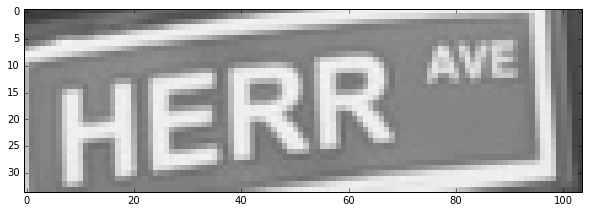

In [64]:
pred(output,dataList,100)